---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

### Saverio Monaco
##### MAT: 2012264

# Homework 1 - Supervised Deep Learning
---
---

## Regression task

The goal of this homework is to implement a Neural Network in a Supervised framework to approximate a scalar function $f:\mathbb{R}\to\mathbb{R}$, in which the training and testing points are generated according to a theoretical and unknown curve, plus some noise:

$$\hat{y}=f(x) + noise$$

For a proper tune of the hyperparameter, Grid-Search and K-Fold cross-validation methods are implemented.

In [1]:
# if True all the models will be loaded from ./models folder
# if False all the models will be trained
load = False

In [2]:
#################
#### IMPORTS ####
#################

# Dataframes and Arrays
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold


In [3]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [4]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


### Dataset and DataLoader 

In [5]:
class CsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        self.data = pd.read_csv(csv_file).to_numpy()
        self.names = pd.read_csv(csv_file).columns
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    

In [6]:
# Remove anything in the data folder
!rm -rf regression_dataset

# DOWNLOADING THE DATA
data_url = "https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/"

# wget without showing the output, I already checked it works
!wget -P regression_dataset {data_url}train_data.csv  &> /dev/null # download training set
!wget -P regression_dataset {data_url}test_data.csv  &> /dev/null # download test set


In [7]:
# We only use ToTensor() transform for this task
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset  = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)


In [8]:
print('Size of training dataset:', train_dataset.__len__() )
print('Size of testing dataset: ', test_dataset.__len__() )


Size of training dataset: 100
Size of testing dataset:  100


Data has been downloaded in the path `./regression_dataset` in two separate csv files: ```./regression_dataset/train_data.csv``` and ```./regression_dataset/test_data.csv``` respectively for the training dataset and testing dataset.


They have been also loaded in RAM as a ```CsvDataset``` class. Let us visualize both training and testing data:

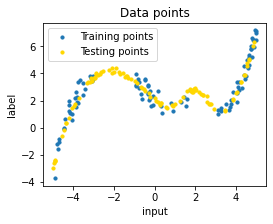

In [9]:
fig = plt.figure(figsize=(4,3))

# Plotting training and test points
plt.scatter(train_dataset.data[:,0], train_dataset.data[:,1], label='Training points', s=10)
plt.scatter(test_dataset.data[:,0], test_dataset.data[:,1], label='Testing points', color='gold', s=10)

plt.title('Data points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.savefig('./imgs/regression/fulldataset.svg', format='svg')


Data seems to be generated from a grade-5 polynomial function. It is worth noticing that the training dataset is not optimal, compared to the testing dataset: it is noisier and it has missing values on the two local maxima. The latter will be the most hard problem to overcome, since it requires the model to properly generalize on those two areas it has never been trained on.

### Building the Neural Network Structure

In [10]:
type(nn.ReLU())

torch.nn.modules.activation.ReLU

In [19]:
class RegFC(nn.Module):
    def __init__(self, Ni, No, Nhs, activation = nn.ReLU(), dropout=0):
        """
        Ni - Input size  (INT)
        No - Output size (INT)
        Nhs - Hidden layers (LIST OF INTEGERS)
        """
        super().__init__()
        nhidden = len(Nhs) # number of hidden layers
        # Creating an array of layers
        Ns = [Ni] + Nhs + [No]
        # First layer
        self.fc1 = nn.Linear(in_features=Ns[0], out_features=Ns[1])
        
        # Hidden layers
        self.hidden = nn.ModuleList()
        for h in range(nhidden-1):
            self.hidden.append(nn.Linear(in_features=Ns[h+1], out_features=Ns[h+2]))
            
        # Last layer
        self.out = nn.Linear(in_features=Ns[-2], out_features=Ns[-1])
        
        self.act = activation
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.act(self.fc1(x))
        
        for h in range(len(self.hidden)):
            x = self.act(self.dropout(self.hidden[h](x)))
        
        x = self.out(x)
        
        return x
    
    def fit(self, data, epochs, folds, torch_loss, printfreq, lr0, reg_term = 0,plotlosses = False, test=False):
        '''
        Function for training the Network
        data:       Dataloader
        epochs:     Number of epochs for the model to learn
        folds:      Folds in the k-fold cross validation
        torch_loss: Torch funcion for the loss
        printfreq:  Frequency of printing train loss and validation loss
        lr0:        Initial Learning rate
        reg_term:   Regularization term L2 penalty
        '''

        # Define the optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr0, weight_decay= reg_term)
        
        train_loss_log = []
        val_loss_log   = []
        test_loss_log  = []
        for epoch in range(epochs):
            ### TRAIN
            train_loss = []
    
            self.to(device)
            self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
        
                kf = KFold(n_splits=folds)
                kf.get_n_splits(x_batch)
        
                loss = 0
                for train_index, val_index in kf.split(x_batch):
                    x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                    y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                    # Forward pass
                    out = self(x_batch_train)
        
                    # Compute loss
                    loss = loss + torch_loss(out, y_batch_train)/folds

                # Backpropagation
                self.zero_grad() # Clears gradient
                loss.backward()  # Computes the derivative of the loss

                # Update the weights
                optimizer.step() # Take a step based on the gradients

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

            # Save average train loss
            train_loss = np.mean(train_loss)
    
            if printfreq!=0 and epoch%printfreq == 0:
                print('#################')
                print(f'# EPOCH {epoch}')
                print('#################')
                print(f"AVERAGE TRAIN LOSS: {train_loss}")
            train_loss_log.append(train_loss)
        
            ### VALIDATION
            val_loss = []
            self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in data:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    kf = KFold(n_splits=folds)
                    kf.get_n_splits(x_batch)
        
                    loss = 0
                    for train_index, val_index in kf.split(x_batch):
                        x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                        y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                        # Forward pass
                        out = self(x_batch_val)

                        # Compute loss
                        loss = loss + torch_loss(out, y_batch_val)/folds
                
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
        
                # Save average validation loss
                val_loss = np.mean(val_loss)
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                    print('')
                val_loss_log.append(val_loss)
                
            # TEST
            if test:
                loss_batch = 0
                self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
                with torch.no_grad(): # Disable gradient tracking
                    for sample_batched in test_dataloader:
                        # Move data to device
                        x_batch = sample_batched[0].to(device)
                        label_batch = sample_batched[1].to(device)
                        
                        # Forward pass
                        pred_batch = self(x_batch)
                        
                        loss_batch = loss_batch + torch_loss(pred_batch, label_batch).detach().cpu().numpy()
                        
                test_loss_log.append(np.mean(loss_batch))
                        
                
        if type(plotlosses)==str:
            fig = plt.figure(figsize=(4,3))
            plt.title('Losses')
            xvalues = np.arange(0,epochs)
            plt.plot(xvalues, test_loss_log  , label='Test error', color='gold')
            plt.plot(xvalues, val_loss_log  , label='Validation error', color='green')
            plt.plot(xvalues, train_loss_log, label='Train error', color='blue')
            plt.legend()
            plt.ylim(-0.2,5)
            plt.savefig('./imgs/regression/'+plotlosses+'.svg', format='svg')
            plt.show()
        
        return train_loss_log[-1], val_loss_log[-1]
    
    def show_regression(self, savefig = False):
        '''
        Plots ALL the training points and the predicted curve
        dloader: dataloader of the training points
        '''
        # Input vector
        x_vec = torch.linspace(np.min(train_dataloader.dataset.data[:,0]),
                               np.max(train_dataloader.dataset.data[:,0]),1000)
        x_vec = x_vec.to(device)
        x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

        self.eval()
        with torch.no_grad(): # turn off gradients computation
            y_vec = self(x_vec)

        # Convert x_vec and y_vec to numpy one dimensional arrays
        x_vec = x_vec.squeeze().cpu().numpy()
        y_vec = y_vec.squeeze().cpu().numpy()

        # Plot output
        fig = plt.figure(figsize=(4,3))
        plt.plot(x_vec, y_vec, label='Network output',color='red')
        plt.scatter(train_dataloader.dataset.data[:,0], train_dataloader.dataset.data[:,1], 
                    label='Training points', s=10)
        
        plt.scatter(test_dataloader.dataset.data[:,0], test_dataloader.dataset.data[:,1], 
                    label='Testing points', color='gold', s=10)

        plt.xlabel('x')
        plt.ylabel('y')
        
        plt.grid()
        plt.legend()
        
        if savefig:
            plt.savefig('./imgs/regression/'+savefig+'.svg', format='svg')
        else:
            plt.show()

    def plot_netweights(self, savefig=False):
        '''
        Get histogram of the weights
        '''
        # FIRST HIDDEN LAYER #
        input_weights  = self.fc1.weight.data.cpu().numpy() # get weights
        input_biases   = self.fc1.bias.data.cpu().numpy()   # get biases

        # FOR EVERY OTHER HIDDEN LAYERS (it can be more than one #
        hidden_weights = []
        hidden_biases  = []
        for h in range(len(self.hidden)):
            hidden_weights.append(self.hidden[h].weight.data.cpu().numpy()) # get weights
            hidden_biases.append(self.hidden[h].bias.data.cpu().numpy())    # get biases

        # LAST LAYER #
        output_weights = self.out.weight.data.cpu().numpy()
        output_biases  = self.out.bias.data.cpu().numpy()

        # Weights histogram
        fig, axs = plt.subplots(2+len(self.hidden), 2, figsize=(12,10))
        # FIRST HIDDEN LAYER #
        axs[0,0].hist(input_weights.flatten(), 50, alpha=0.6, ec="k")
        axs[0,0].set_title('First hidden layer weights')
        axs[0,1].hist(input_biases.flatten(), 50, color='orange', alpha=0.6, ec="k")
        axs[0,1].set_title('First hidden layer biases')
        # FOR EVERY OTHER HIDDEN LAYERS #
        for h in range(len(self.hidden)):
            axs[h+1,0].hist(hidden_weights[h].flatten(), 50, alpha=0.6, ec="k")
            axs[h+1,0].set_title('Hidden layer '+str(h+1)+' weights')
            axs[h+1,1].hist(hidden_biases[h].flatten(), 50, color='orange', alpha=0.6, ec="k")
            axs[h+1,1].set_title('Hidden layer '+str(h+1)+' biases')
        # LAST LAYER #
        axs[len(self.hidden)+1,0].hist(output_weights.flatten(), 50, alpha=0.6, ec="k")
        axs[len(self.hidden)+1,0].set_title('Output layer weights')
        axs[len(self.hidden)+1,1].hist(output_biases.flatten(), 50, color='orange', alpha=0.6, ec="k")
        axs[len(self.hidden)+1,1].set_title('Output layer bias')
        
        fig.subplots_adjust(hspace=0.8)
        
        if savefig:
            plt.savefig('./imgs/regression/'+savefig+'.svg', format='svg')
        else:
            plt.show()
        
    def plot_netactivations(self, xs, savefig=False):
        def get_activation(layer, input, output):
            global activation
            activation = torch.relu(output)
    
        hook_handle = self.hidden[len(self.hidden)-1].register_forward_hook(get_activation)
    
        ### Analyze activations
        net = self.to(device)
        net.eval()
    
        fig, axs = plt.subplots(len(xs), 1, figsize=(12,2*len(xs)))
    
        with torch.no_grad():
            for i, x in enumerate(xs):
                x_act = torch.tensor([x]).float().to(device)
                y_act = self(x_act)
                z_act = activation
            
                axs[i].stem(z_act.cpu().numpy(), use_line_collection=True)
                axs[i].set_title('Last layer activations for input x=%.2f' % x)
            
        ### Remove hook
        hook_handle.remove()
    
        plt.tight_layout()
        
        if savefig:
            plt.savefig('./imgs/regression/'+savefig+'.svg', format='svg')
        else:
            plt.show()
        
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/bestregressor.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/bestregressor')
            

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 100, shuffle=True, num_workers=0)


## Grid-search

Here the Grid-search is implemented, models will be trained with every possible combination of parameters and the parameters that will generate the lowest-error model will be saved in a dictionary ```best_config```.

---------------------
Configuration 0
 Validation loss:  0.9731962
 Lr =            0.01
 Loss =          MSELoss()
 Reg =           0.01
 hidden_layers = [1000, 1000, 1000]
 dropout =       0.01
 activation =    Tanh()

Iteration: 1
---------------------
Configuration 1
 Validation loss:  0.34943622
 Lr =            0.01
 Loss =          MSELoss()
 Reg =           0.01
 hidden_layers = [1000, 1000, 1000]
 dropout =       0.1
 activation =    Tanh()

Iteration: 2
Iteration: 3
Iteration: 4
---------------------
Configuration 4
 Validation loss:  0.32202393
 Lr =            0.001
 Loss =          MSELoss()
 Reg =           0.01
 hidden_layers = [1000, 1000, 1000]
 dropout =       0.01
 activation =    Tanh()

Iteration: 5
---------------------
Configuration 5
 Validation loss:  0.29697835
 Lr =            0.001
 Loss =          MSELoss()
 Reg =           0.01
 hidden_layers = [1000, 1000, 1000]
 dropout =       0.1
 activation =    Tanh()

Iteration: 6
Iteration: 7
Iteration: 8
Best mode

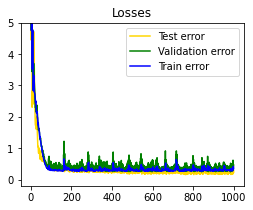

In [13]:
if load:
    best_net =  Net(1,1,grid_hlayer,activation =nn.Tanh(), dropout=0)
    best_net.load_state_dict(torch.load('./models/bestregressor.pth'))
else:
    # Hyperparameters for the gridsearch:
    grid_lrs = [1e-2,1e-3]
    grid_losses = [nn.MSELoss()] #nn.L1Loss(),
    grid_regs = [1e-2,1e-1]
    grid_hlayers = [[1000,1000,1000]] #[[1000,1000],[1000,1000,1000]]
    grid_dropouts = [.01, .1]
    grid_activations = [nn.Tanh()]

    best_train_loss = 1000000
    best_val_loss   = 1000000

    i = 0

    for grid_lr in grid_lrs:
        for grid_loss in grid_losses:
            for grid_reg in grid_regs:
                for grid_hlayer in grid_hlayers:
                    for grid_dropout in grid_dropouts:
                        for grid_activation in grid_activations:
                            # For every possible combination of hyperparameters...
                            grid_net = RegFC(1,1,grid_hlayer,activation = grid_activation, dropout=grid_dropout)
                            grid_train_loss, grid_val_loss = grid_net.fit(train_dataloader,500,5,
                                                             grid_loss,0,grid_lr,reg_term = grid_reg)
                
                            if grid_val_loss < best_val_loss:
                                best_val_loss = grid_val_loss
                    
                                # Save the best combination of the hyperparameters in a dictionary
                                # so we can inspect the best model later
                                best_config = {
                                  "lr":            grid_lr,
                                  "loss":          grid_loss,
                                  "reg":           grid_reg,
                                  "hidden layers": grid_hlayer,
                                  "dropout":       grid_dropout,
                                  "activation":    grid_activation}
                
                                if True: # Set to False, too much useless information displayed
                                    print('---------------------')
                                    print('Configuration', i)
                                    print(' Validation loss: ', grid_val_loss)
                                    print(' Lr =           ', grid_lr)
                                    print(' Loss =         ', grid_loss)
                                    print(' Reg =          ', grid_reg)
                                    print(' hidden_layers =', grid_hlayer)
                                    print(' dropout =      ', grid_dropout)
                                    print(' activation =   ', grid_activation)
                                    print('')
                
                            i = i + 1
                            print('Iteration:',i)
                    
     
    print('Best model found: ')
    print(best_config)

    # Initialize and train the model with the best configurations, so we can see how it performs
    best_net = RegFC(1,1,best_config["hidden layers"], activation = best_config["activation"],
              dropout=best_config["dropout"])
    best_net.fit(train_dataloader,500,5,best_config["loss"],0,best_config["lr"],
              reg_term = best_config["reg"],plotlosses='bestreg_losses', test=True)
    best_net.save()


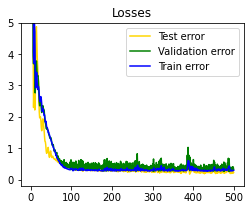

In [20]:
# Initialize and train the model with the best configurations, so we can see how it performs
best_net = RegFC(1,1,best_config["hidden layers"], activation = best_config["activation"],
          dropout=best_config["dropout"])
best_net.fit(train_dataloader,500,5,best_config["loss"],0,best_config["lr"],
          reg_term = best_config["reg"],plotlosses='bestreg_losses', test=True)
best_net.save()

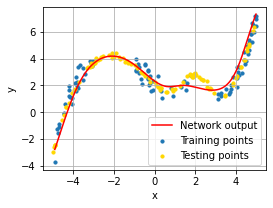

In [15]:
best_net.show_regression(savefig = 'bestreg_performance')


In [ ]:
print('MSE on Val:', best_val_loss)

### Weight histogram

Gridsearch Network:


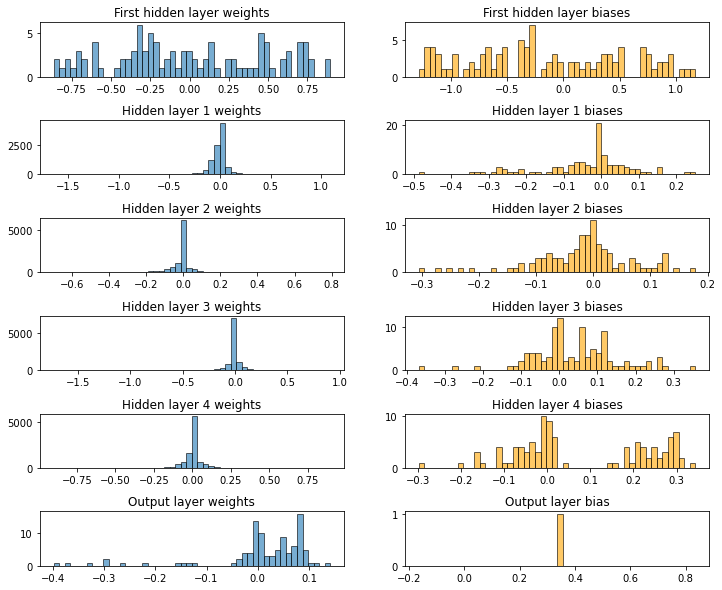

In [13]:
print('Gridsearch Network:')
best_net.plot_netweights(savefig='bestreg_weights')

Untrained Network:


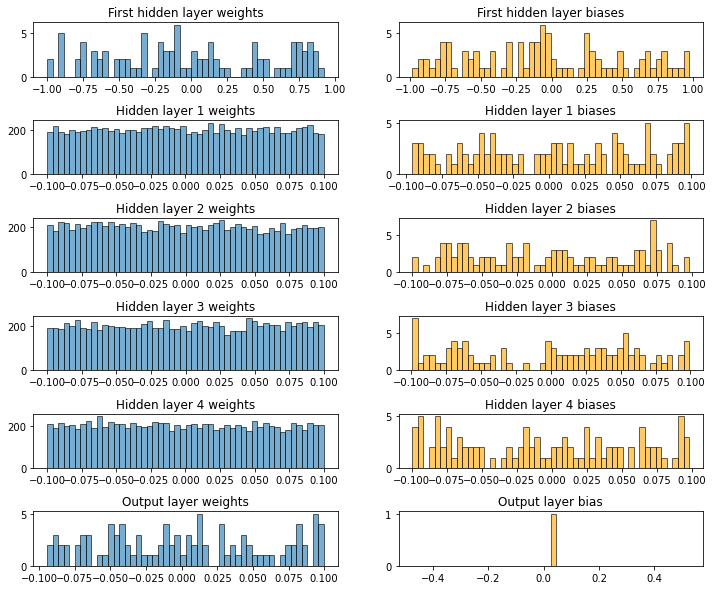

In [14]:
untrained_net = RegFC(1,1,best_config["hidden layers"], activation = best_config["activation"],
          dropout=best_config["dropout"])

print('Untrained Network:')
untrained_net.plot_netweights(savefig='untrained_weights')

### Activation Profile

Gridsearch Network:


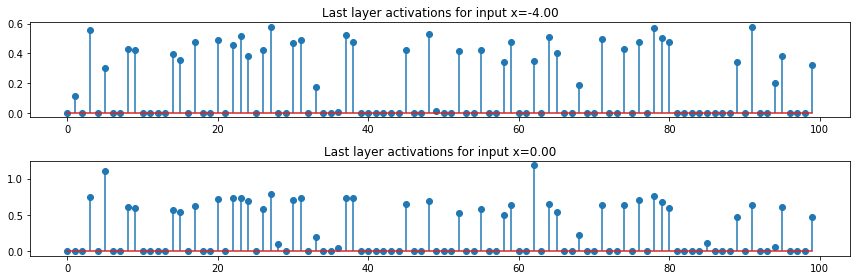

In [15]:
print('Gridsearch Network:')
best_net.plot_netactivations([-4,0], savefig='bestreg_activations')


Untrained Network:


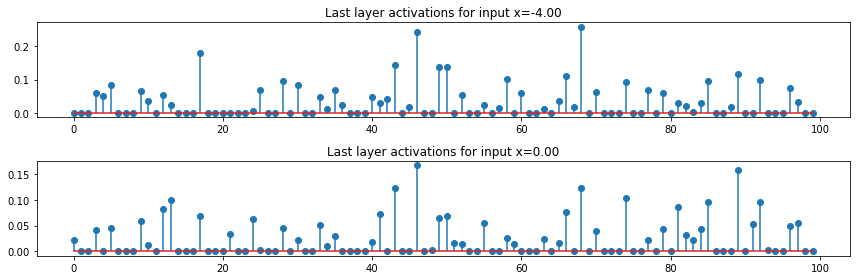

In [16]:
print('Untrained Network:')
untrained_net.plot_netactivations([-4,0], savefig='untrained_activations')


## Appendix

Here I placed some tests and interesting insights.

### Test: K-Fold Cross-validation

Here is a quick test to check if K-Fold Cross-Validation split was implemented correctly.

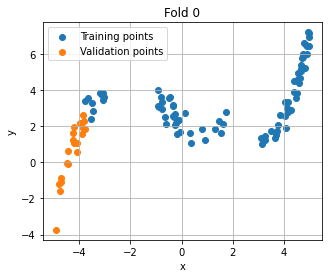

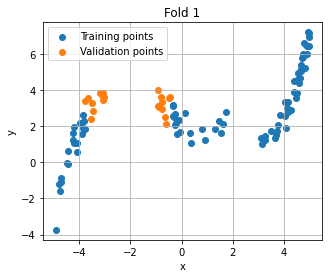

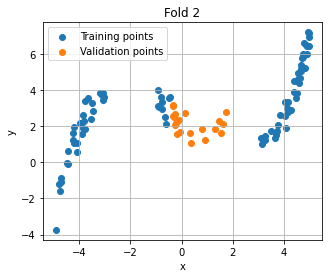

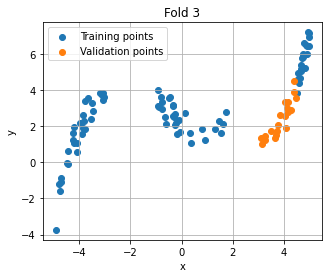

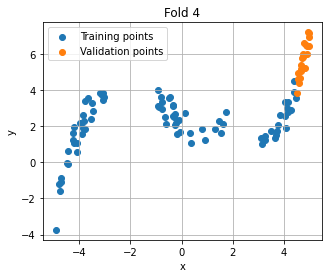

In [17]:
# Create a copy of the data array
kfold_data = train_dataset.data

# Ordering the copy of the data array, so that it's easier to visualize if the kfold worked or not
kfold_data = kfold_data[kfold_data[:,0].argsort()]
k = 0

kf = KFold(n_splits=5)
kf.get_n_splits(kfold_data[:,0])
for train_index, val_index in kf.split(kfold_data[:,0]):
    #print("Fold "+str(k))
    #print("   VAL:", val_index)
    X_train, X_val = kfold_data[:,0][train_index], kfold_data[:,0][val_index]
    y_train, y_val = kfold_data[:,1][train_index], kfold_data[:,1][val_index]
    
    plt.figure(figsize=(5,4))
    plt.title("Fold "+str(k))
    plt.scatter(X_train, y_train, label='Training points')
    plt.scatter(X_val, y_val, label='Validation points')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()
    k = k + 1
    

K-Fold seems to be successfully applied, of course for the training of the model, the dataset will be randomly shuffled before


### Polynomial model

In this case the data is cleary generated from a polynomial curve. However it is not always clear the underlying type of model that has generated the data.

Supposing in this case we know for sure (prior knowledge) that data has been generated from a noisy polynomial model, we can try to fit our points with a polynomial curve using the Least Square method.

Focussing on this subclass of models has better performances in training, but a lower generalziation factor.

In [39]:
# y = [a] + [b]x + [c]x^2 + noise
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    #print(x_matrix)
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

def least_squares(x, y, pol_order, reg_term):
    """
    Implement the least square algorithm to fit a polynomial function of order "pol_order"
    INPUT
        x: training x data
        y: training y data
        pol_order: order of the fitting polynomial function
        reg_term: regularization term
    OUTPUT
        beta_est: estimated parameter vector
    """
    
    # Create the Y matrix
    Y = y.reshape(len(y), 1)
    # Create the X matrix
    X = np.array([x**i for i in range(pol_order+1)]).transpose()
    
    # RLS algorithm
    gram_matrix = np.matmul(X.transpose(), X) + reg_term * np.identity(X.shape[1])
    gram_matrix_inv = np.linalg.inv(gram_matrix)
    temp = np.matmul(gram_matrix_inv, X.transpose())
    beta_est = np.matmul(temp, Y)
    
    return beta_est.squeeze()

def polynomial_model_compute_valerr(params,valset_x,valset_y):
    """
    Computes the MSE of the polinomial found (coefficients) with the testing set
    INPUT
        params: coefficients of the polinomial
        valset_x: x-values of the validation set
        valset_y: y-values of the validation set
    """
    err = 0
    for i in range(len(valset_x)): # For every point
        predicted = 0 # Error of i-th point
        for g in range(len(params)):
            predicted = predicted + params[g]*valset_x[i]**g
        err = err + (valset_y[i] - predicted)**2
        
    return err/len(valset_x)


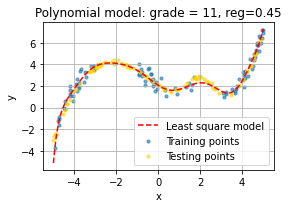

In [48]:
regs = np.linspace(0,5,100)
lowest_err = 100000
best_reg = 0
best_grade = 0
pgrademax = 15

for reg in regs:
    for pgrade in range(3,pgrademax):
        params = least_squares(train_dataloader.dataset.data[:,0], train_dataloader.dataset.data[:,1], pgrade, reg)
        
        curr_err = polynomial_model_compute_valerr(params,test_dataloader.dataset.data[:,0], test_dataloader.dataset.data[:,1])
    
        if curr_err < lowest_err:
            best_grade = pgrade
            best_reg = reg
            best_betas = params
            lowest_err = curr_err
    
plt.figure(figsize=(4,3))

x_highres = np.linspace(-5,5,1000)
plt.plot(x_highres, poly_model(x_highres, best_betas), color='red', ls='--', label='Least square model')
plt.scatter(train_dataset.data[:,0], train_dataset.data[:,1], label='Training points', alpha=0.6, s=10)
plt.scatter(test_dataset.data[:,0], test_dataset.data[:,1], label='Testing points', color='gold', alpha=0.6, s=10)

plt.title('Polynomial model: grade = '+str(best_grade)+', reg='+str(round(best_reg,2)))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/regression/polymodel.svg', format='svg')


In [42]:
print('MSE on Test:', lowest_err)

MSE on Test: 0.15142560620830506
